In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 

start_date = '2018-06-01'
end_date = '2018-06-15'

start_dt = (dt.datetime.strptime(start_date, "%Y-%m-%d")).date()
end_dt = (dt.datetime.strptime(end_date, "%Y-%m-%d")).date()

startdate_previous_yr = start_dt - dt.timedelta(days=365)
enddate_previous_yr = end_dt - dt.timedelta(days=365)

In [11]:
temps = calc_temps(startdate_previous_yr, enddate_previous_yr)
temp_min = temps[0][0]
temp_avg = round(temps[0][1], 2)
temp_max = temps[0][2]

In [12]:
print(f"start date: {start_date}")
print(f"end date: {end_date}")
print(f"Temperatures from {startdate_previous_yr } to {enddate_previous_yr }:")
print(f"Minimum temp: {temp_min}")
print(f"Average temp: {temp_avg}")
print(f"Max temp: {temp_max}")

start date: 2018-06-01
end date: 2018-06-15
Temperatures from 2017-06-01 to 2017-06-15:
Minimum temp: 72.0
Average temp: 77.42
Max temp: 83.0


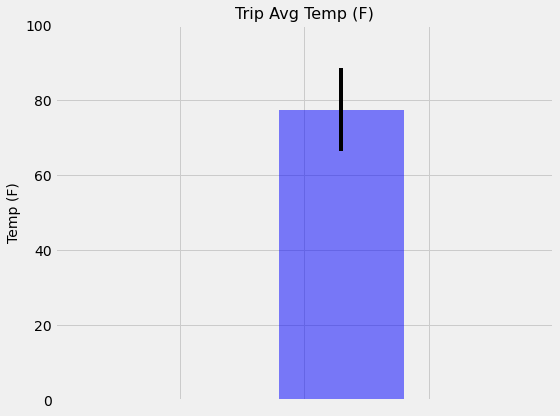

In [13]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

y_err= temp_max-temp_min

plt.figure(figsize = (8,6))
plt.bar(2.0, height=temp_avg, yerr=y_err, width = 1, color='blue', alpha = 0.5,  align='center')
xaxis_values = np.arange(-0.3,3.8, step=1)
plt.title("Trip Avg Temp (F)", fontsize = 16)
plt.ylabel("Temp (F)", fontsize=14)
plt.ylim(0,100)
plt.xticks(xaxis_values, "")
plt.tight_layout()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

## Daily Rainfall Average

In [14]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

prcp_station_df = pd.DataFrame(session.query(measurement.date, measurement.station, measurement.prcp).\
                               filter((measurement.date >= startdate_previous_yr) & \
                               (measurement.date <= enddate_previous_yr)).all())


prcp_station_df.head()



,date,station,prcp
0,2017-06-01,USC00519397,0.00
1,2017-06-02,USC00519397,0.00
2,2017-06-03,USC00519397,0.02
3,2017-06-04,USC00519397,0.00
4,2017-06-05,USC00519397,0.00


In [15]:
station_df = pd.DataFrame(session.query(station.station, station.name, station.latitude, station.longitude,\
                                        station.elevation).all())
station_df.head()

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [16]:
# drop na's
prcp_station_df.dropna(axis=0, how="any", inplace=True)
prcp_station_df

,date,station,prcp
0,2017-06-01,USC00519397,0.00
1,2017-06-02,USC00519397,0.00
2,2017-06-03,USC00519397,0.02
3,2017-06-04,USC00519397,0.00
4,2017-06-05,USC00519397,0.00
...,...,...,...
92,2017-06-11,USC00516128,0.70
93,2017-06-12,USC00516128,0.81
94,2017-06-13,USC00516128,0.65
95,2017-06-14,USC00516128,0.81


In [17]:
total_prcp = pd.DataFrame(prcp_station_df.groupby('station').sum())
total_prcp

,prcp
station,
USC00513117,1.96
USC00514830,2.02
USC00516128,5.51
USC00519281,2.98
USC00519397,0.16
USC00519523,0.76


In [18]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_per_station_df = pd.merge(total_prcp, station_df, on="station").rename(columns={"prcp":"total precipitation (in)"})
rainfall_per_station_df.sort_values('total precipitation (in)', ascending=False, inplace=True)
rainfall_per_station_df.reset_index(inplace=True, drop=True)
rainfall_per_station_df

,station,total precipitation (in),name,latitude,longitude,elevation
0,USC00516128,5.51,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,2.98,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00514830,2.02,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00513117,1.96,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519523,0.76,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.16,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [19]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

start_dt = (dt.datetime.strptime(start_date, "%Y-%m-%d")).date()
end_dt = (dt.datetime.strptime(end_date, "%Y-%m-%d")).date()

In [21]:
# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [23]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session

In [24]:
# Close Session
session.close()